# **Aspect based Emotion Analysis**

# Importing Libraries

In [ ]:
import io
import re
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
!pip install sklearn-crfsuite
!python -m spacy download en_core_web_lg
import spacy 
!python -m spacy download en
!pip3 install nrclex
from nrclex import NRCLex
from pathlib import Path
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from pathlib import Path

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords



from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle
import nltk
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from nltk.corpus import stopwords


!pip3 install stanza
!pip install text2emotion
import text2emotion as te
import operator
import stanza
stanza.download('en')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 747kB 4.3MB/s 
     |████████████████████████████████| 827.9MB 1.5MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=276cb9d7a52b41832262e3ec593228dc6de55fb0ee8f06f1ff30bb3032843ca9
  Stored in directory: /tmp/pip-ephem-wheel-cache-xdeg_ge_/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Download and installation successful
You can now load the model via spacy.load

2020-12-12 07:10:14 INFO: Downloading default packages for language: en (English)...
2020-12-12 07:11:07 INFO: Finished downloading models and saved to /root/stanza_resources.


## IOB files to sentences  

Converted the XML into IOB files which contains the information of aspect words in the sentences. 

In [ ]:
file_train=open("/content/train_mod.iob","r")  #converting iob file into sentences
Train=[]
sent=[]
count_train=0
for line in file_train:
  count_train=count_train+1
  if line=='\n':
    Train.append(sent)
    sent=[]
  else:
    sent.append([i for i in line.split()][:3])

In [ ]:
for i in range(len(Train)):#add pos tag to each word
  for j in range(len(Train[i])):
    a = Train[i][j]
    a.insert(1,nltk.pos_tag(nltk.word_tokenize(a[0]))[-1][1])
    Train[i][j] = a 

## Making features from the extracted data for training the CRF model 

In [ ]:
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'curr_word': word.lower(),
        'curr_pos':  sent[i][1],
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isdigit()': word.isdigit(),
        'prev_pos': '.',
        'prev_word': '.',
    }
    if i > 0:
        features.update({
            'prev_word': sent[i-1][0].lower(),
            'prev_pos': sent[i-1][1],
            #'prev_chunk':  sent[i-1][2],  
        })
    else:
        features['BOS'] = True

    if i > 1:
        features.update({
            'prev_prev_word': sent[i-2][0],
            'prev_prev_pos': sent[i-2][1],
          # 'prev_prev_chunk':  sent[i-2][2],    
        })

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]
  

## Converting sentences into features for training

In [ ]:

X_train = [sent2features(s) for s in Train] #convert sentences into crf input format
y_train = [sent2labels(s) for s in Train]

## Training the CRF Model

In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)
labels = list(crf.classes_)
y_pred_t = crf.predict(X_train)
print(metrics.flat_classification_report(y_train, y_pred_t,labels = labels,digits =4 ))

              precision    recall  f1-score   support

           O     0.9960    0.9951    0.9956     22497
         B-A     0.9419    0.9495    0.9457      1743
         I-A     0.9869    0.9947    0.9908       759

    accuracy                         0.9919     24999
   macro avg     0.9750    0.9798    0.9774     24999
weighted avg     0.9920    0.9919    0.9919     24999



We can see the model trained quite good

## Processing the Train data for checking the CRF model for aspect extraction

In [ ]:
file_train=open("/content/test_mod.iob","r") #converting iob into sentences
Test=[]
sent=[]
count_train=0
for line in file_train:
  count_train=count_train+1
  if line=='\n':
    Test.append(sent)
    sent=[]
  else:
    sent.append([i for i in line.split()][:3])

In [ ]:
for i in range(len(Test)):
  for j in range(len(Test[i])):
    a = Test[i][j]
    a.insert(1,nltk.pos_tag(nltk.word_tokenize(a[0]))[-1][1])
    Test[i][j] = a 

## Converting test sentences into features to pass into trained CRF model for aspect extraction

In [ ]:
X_test = [sent2features(s) for s in Test] #converting test files crf input format
y_test = [sent2labels(s) for s in Test]

In [ ]:
len(X_test)

676

## Making predictions for aspects on the test data

In [ ]:
labels = list(crf.classes_)
from sklearn_crfsuite import metrics
y_pred = crf.predict(X_test)
#print(metrics.flat_classification_report(y_test, y_pred,labels=labels,digits =4 ))

## From predictions, extracting the aspect words per sentence and storing it in a asp_list

In [ ]:
'''
extracting aspect terms after passing through crf model
'''
asp_list = [] 
for k in range(len(X_train)):
  aspect = []
  x = ''
  i=0
  while (i < len(X_train[k])):
    if(y_pred_t[k][i]=='B-A'):
      x = X_train[k][i]['curr_word']
      if(i<len(X_train[k])-1):
        while(y_pred_t[k][i+1]=='I-A'):
          x = x +' '+X_train[k][i+1]['curr_word']
          i=i+1
          if(i==len(y_pred_t[k])-1):
            break
      aspect.append(x)

    i = i+1
  asp_list.append(aspect)

In [ ]:
len(asp_list),len(y_pred),len(X_test),len(Test)   #aspect list

(2000, 676, 676, 676)

## Utility functions for extracting ground truth data per sentences - text, opinion per aspect, polarity

In [ ]:
'''
parsing xml file to extract opinions,sentences,polarity etc
'''
def raw2dict(sentence_nodes):
    """
    Input: a soup object, e.g. soup.find_all("sentence")
    Output: a list of dictionaries, contains id, text, aspect terms
    """
    sentences = []
    aspects_list = []
    aspect_category = []
    s = []
    i = 0
    for n in sentence_nodes:
        i += 1
        sentence = {}
        aspect_term = []
        aspect_cat = []
        sentence['id'] = i
        sentence['text'] = n.find('text').string
        sentence['aspect_polarity']={}
        s.append(sentence['text'])
        if n.find('Opinions'):
            for c in n.find('Opinions').contents:
                if c.name == 'Opinion':
                    if c['target'] not in aspect_term:
                        aspect_term.append(c['target'])
                        sentence['aspect_polarity'][c['target'].lower()]=c['polarity']
                        aspect_cat.append(c['category'])

        aspect_category.append(aspect_cat)                
        aspects_list.append(aspect_term)
        sentence['aspect'] = aspect_term
        sentences.append(sentence)
        
    return sentences,aspects_list,aspect_category,s

**bold text**## Extracting Ground truth information from train XML

In [ ]:
'''
parsing xml file to extract opinions,sentences,polarity etc
'''
train_file = Path.cwd().parent.joinpath('/content/train.xml')
soup = None
with train_file.open(encoding="utf-8") as f:
    soup = BeautifulSoup(f.read().strip(), "lxml-xml")

if soup is None:
    raise Exception("Can't read xml file")

sentence_nodes = soup.find_all("sentence")
sentences,aspects_list,aspect_category,sent_list = raw2dict(sentence_nodes)

In [ ]:
opinion = soup.find_all("Opinion")

In [ ]:
sentences[0:10]  #sentence list
#aspect_category

[{'aspect': ['place'],
  'aspect_polarity': {'place': 'negative'},
  'id': 1,
  'text': 'Judging from previous posts this used to be a good place, but not any longer.'},
 {'aspect': ['staff'],
  'aspect_polarity': {'staff': 'negative'},
  'id': 2,
  'text': 'We, there were four of us, arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude.'},
 {'aspect': ['NULL'],
  'aspect_polarity': {'null': 'negative'},
  'id': 3,
  'text': 'They never brought us complimentary noodles, ignored repeated requests for sugar, and threw our dishes on the table.'},
 {'aspect': ['food', 'portions'],
  'aspect_polarity': {'food': 'negative', 'portions': 'negative'},
  'id': 4,
  'text': 'The food was lousy - too sweet or too salty and the portions tiny.'},
 {'aspect': ['NULL'],
  'aspect_polarity': {'null': 'negative'},
  'id': 5,
  'text': 'After all that, they complained to me about the small tip.'},
 {'aspect': ['place'],
  'aspect_polarity': {'p

In [ ]:
aspects_list[0:10]

[['place'],
 ['staff'],
 ['NULL'],
 ['food', 'portions'],
 ['NULL'],
 ['place'],
 ['food'],
 ['Saul'],
 ['foie gras terrine with figs', 'duck confit'],
 ['wine list']]

In [ ]:
asp_list[0:10]

[['place'],
 ['staff'],
 [],
 ['food', 'portions'],
 [],
 ['place'],
 ['food'],
 ['saul'],
 ['duck confit', 'foie gras terrine with figs'],
 ['wine list']]

In [ ]:
asp_category = ['service', 'food', 'anecdotes/miscellaneous', 'price', 'ambience']

## Loading spacy library to check similarities between aspect word and categories

In [ ]:
nlp = spacy.load("en")

In [ ]:
# dict = {}
# for i in range(len(asp_list)):
#   for j in range(len(asp_list[i])):
#       max = 0
#       for k in range(len(asp_category)):
#         w1 = nlp(asp_list[i][j])
#         w2 = nlp(asp_category[k])
#         if(w1.similarity(w2) > max):
#           max = w1.similarity(w2)
#           dict[asp_list[i][j]] = asp_category[k]

In [ ]:
#dict

In [ ]:
#asp_list[0:10]

In [ ]:
'''
clean the data
'''
def clean_data(w):
    w=w.lower()
    w=re.sub(' +', ' ', w).strip(' ')
    w=re.sub(r'[^\w\s]','',w)
    w=re.sub(r"([0-9])", r" ",w)
    w=re.sub("(.)\\1{2,}", "\\1", w)
    return w

In [ ]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

## extracting dependency relations from sentences

In [ ]:
'''
extracting dependency relations from sentences
'''
def dependencies(txt,nlp):
  finaltxt = txt
  stop_words = set(stopwords.words('english'))
  new_txt_list = nltk.word_tokenize(finaltxt)
  wordsList = [w for w in new_txt_list]
  #taggedList = nltk.pos_tag(wordsList)
  pos = nlp(txt)
  taggedList = []
  for dep_edge in pos.sentences[0].dependencies:
      taggedList.append([dep_edge[2].text, dep_edge[2].xpos])
  newwordList = []
  flag = 0
  for i in range(0,len(taggedList)-1):
      if(taggedList[i][1]=="NN" and taggedList[i+1][1]=="NN"):
          newwordList.append(taggedList[i][0]+taggedList[i+1][0])
          flag=1
      else:
          if(flag==1):
            flag=0
            continue
          newwordList.append(taggedList[i][0])
          if(i==len(taggedList)-2):
              newwordList.append(taggedList[i+1][0])
  finaltxt = ' '.join(word for word in newwordList)
  doc = nlp(finaltxt)
  dep_node = []
  for dep_edge in doc.sentences[0].dependencies:
      dep_node.append([dep_edge[2].text, dep_edge[0].id, dep_edge[1]])
  for i in range(0, len(dep_node)):
      if (int(dep_node[i][1]) != 0):
        dep_node[i][1] = newwordList[(int(dep_node[i][1]) - 1)]
  return dep_node

In [ ]:
nlp = stanza.Pipeline()


2020-12-12 07:11:19 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| sentiment | sstplus   |
| ner       | ontonotes |

2020-12-12 07:11:19 INFO: Use device: cpu
2020-12-12 07:11:19 INFO: Loading: tokenize
2020-12-12 07:11:19 INFO: Loading: pos
2020-12-12 07:11:20 INFO: Loading: lemma
2020-12-12 07:11:20 INFO: Loading: depparse
2020-12-12 07:11:22 INFO: Loading: sentiment
2020-12-12 07:11:23 INFO: Loading: ner
2020-12-12 07:11:24 INFO: Done loading processors!


In [ ]:
print(dependencies("The food is great but the service is very bad",nlp))

[['The', 'food', 'det'], ['food', 'great', 'nsubj'], ['is', 'great', 'cop'], ['great', 0, 'root'], ['but', 'bad', 'cc'], ['the', 'service', 'det'], ['service', 'bad', 'nsubj'], ['is', 'bad', 'cop'], ['very', 'bad', 'advmod'], ['bad', 'great', 'conj']]


# Extracting Emotion words given an aspect list

In [ ]:
'''
extracting emotion related words from sentences
'''
def words(txt,featureList,nlp):
  dep_node = dependencies(txt,nlp)
  if(dep_node==0): return 0
  fcluster = {}
  for i in featureList:
      filist = []
      for j in dep_node:
          if((j[0]==i or j[1]==i) and (j[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound","obl"])):
              bool = 0
              if(j[0]==i):
                for k in dep_node: 
                  if(k[1]==j[1] and k[0] in ['not','nor','neither']):
                    filist.append(k[0]+' '+ k[1])
                    bool = 1
                    break
                  elif(k[0]==j[1] and k[1] in ['not','nor','neither']):
                    filist.append(k[1]+' '+ k[0])
                    bool = 1
                    break
                if (bool==0):
                  filist.append(j[1])
              else :
                for k in dep_node: 
                  if(k[1]==j[0] and k[0] in ['not','nor','neither']):
                    filist.append(k[0]+' '+ k[1])
                    bool = 1
                  elif(k[0]==j[0] and k[1] in ['not','nor','neither']):
                    filist.append(k[1]+' ' +k[0])
                    bool =1
                    break   
                if(bool==0):               
                  filist.append(j[0])
      fcluster[i]=filist
  return fcluster

In [ ]:
txt = "But the staff is so horrible to us"
aspects = ['staff']
print(words(txt,aspects,nlp))

{'staff': ['horrible']}


In [ ]:
txt = "The food is best in the restaurant but price is high"
aspects = ['food','price']
print(words(txt,aspects,nlp))

{'food': ['best'], 'price': ['high']}


In [ ]:
txt = "The food was good but service was bad"
aspects = ['food','service']
print(words(txt,aspects,nlp))

{'food': ['good'], 'service': ['bad']}


In [ ]:
txt = "Not only was the food outstanding, but the little perks were great"
aspects = ['food','perks']
print(words(txt,aspects,nlp))

{'food': ['outstanding'], 'perks': ['little', 'great']}


## Emotion Tagger - Rule Based

Using the dependency word extractor, we applied the different emotion tagging techniques on the extracted aspects

1.   Using NRC Lexicon:
  - Use the extracted words, 
  - parse them using nrc lexicon, 
  - attach emotion to the aspect
  - Using the emotion, attach polarity


---




2.    Using text2emotion:
  - Use the extracted words, 
  - parse them using text2emotion library, 
  - attach emotion to the aspect
  - Using the emotion, attach polarity


In [ ]:
'''
For NRC lexicon based tagger
input: emotion_words_per_aspect_dict generated from Words function
output: polarity and emotion dictionary per aspect per sentence
'''
def emotion_tagger(emotion_words_per_aspect_dict):
  temp={}
  emotions={}
  for aspect in emotion_words_per_aspect_dict.keys():
    temp[aspect]="neutral"
    emotion_words = emotion_words_per_aspect_dict[aspect]
    pos=0
    neg=0
    part_sent =str(aspect)
    for word in emotion_words:
      part_sent+=" "+word
    for word in emotion_words:
      pos+=NRCLex(word).affect_frequencies["positive"]
      neg+=NRCLex(word).affect_frequencies["negative"]
    emots = NRCLex(part_sent).affect_frequencies
    if emots['positive']>=emots['negative']:
      temp[aspect]='positive'
    elif emots['positive']<emots['negative']:
      temp[aspect]='negative'
    max_=0
    max_emotion="neutral"
    for k,v in  emots.items():
      if v>max_:
        max_=v
        max_emotion=k
    emotions[aspect]=max_emotion
  return temp,emotions
'''
For text2emotion based tagger
input: emotion_words_per_aspect_dict generated from Words function
output: polarity and emotion dictionary per aspect per sentence
'''
def emotion_tagger2(emotion_words_per_aspect_dict):
  temp={}
  emotions={}
  for aspect in emotion_words_per_aspect_dict.keys():
    temp[aspect]="neutral"
    emotion_words = emotion_words_per_aspect_dict[aspect]
    part_sent =str(aspect)
    for word in emotion_words:
      part_sent+=" "+word
    #print(part_sent)
    emotions_part=te.get_emotion(part_sent)
    #print(type(emotions_part))
    max_=0
    max_emotion="neutral"
    for k,v in  emotions_part.items():
      if v>max_:
        max_=v
        max_emotion=k
    #print(max_emotion)
    if max_emotion in ['Happy','Surprise','neutral']:
      temp[aspect]='positive'
    elif max_emotion=='neutral':
      temp[aspect]='neutral'
    else:
      temp[aspect]='negative'

   
    emotions[aspect]=max_emotion
    
  return temp,emotions




In [ ]:
print(emotion_tagger2({'food': ['outstanding'], 'perks': ['little', 'great']}))
te.get_emotion("Food outstanding")

({'food': 'positive', 'perks': 'positive'}, {'food': 'Happy', 'perks': 'Happy'})


{'Angry': 0.0, 'Fear': 0.0, 'Happy': 1.0, 'Sad': 0.0, 'Surprise': 0.0}

## Emotion tagger - ML approaches

Using ML based methods for tagging emotions
- Training on data with emotion tagged sentences
- using the trained model and bag of words approach generate emotion for each aspect

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Preparing data for traiing various ML models

The following code snippets are referred from https://github.com/lukasgarbas/nlp-text-emotion for data preparation and training the model

In [ ]:
df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')

X_train = df_train.Text
X_test = df_test.Text

y_train = df_train.Emotion
y_test = df_test.Emotion

class_names = ['joy', 'sadness', 'anger', 'neutral', 'fear']
data = pd.concat([df_train, df_test])
data.head()

,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...


## Preprocessing data - cleaning

In [ ]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

## Vectorizing the sentences using tf-idf

In [ ]:
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.Text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)


## Training a SVM emotion predictor model

In [ ]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)



# ysvm_pred = svc.predict(X_test_vect)

# print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
# print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
# print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=1e-05,
          verbose=0)

## SVM based emotion tagger

Using dependency words and converting them into input for svm based emotion predictor we tag each aspect to their emotion and polarity

In [ ]:
def emotion_tagger_SVM(emotion_words_per_aspect_dict):
  temp={}
  emotions={}
  for aspect in emotion_words_per_aspect_dict.keys():
    temp[aspect]="neutral"
    emotion_words = emotion_words_per_aspect_dict[aspect]
    part_sent =str(aspect)
    for word in emotion_words:
      part_sent+=" "+word
    #print(part_sent)
    sent = pd.Series(part_sent)
    sent_test=vect.transform(sent)

    max_emotion = svc.predict(sent_test)[0]

    if max_emotion in ['joy','neutral']:
      temp[aspect]='positive'
    elif max_emotion=='neutral':
      temp[aspect]='neutral'
    else:
      temp[aspect]='negative'
    emotions[aspect]=max_emotion

   

    
  return temp,emotions

## Training a Logistic Regression emotion predictor model

In [ ]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_vect, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Logistic Regression based emotion tagger

In [ ]:
def emotion_tagger_lgr(emotion_words_per_aspect_dict):
  temp={}
  emotions = {}
  for aspect in emotion_words_per_aspect_dict.keys():
    temp[aspect]="neutral"
    emotion_words = emotion_words_per_aspect_dict[aspect]
    part_sent =str(aspect)
    for word in emotion_words:
      part_sent+=" "+word
    #print(part_sent)
    sent = pd.Series(part_sent)
    sent_test=vect.transform(sent)

    max_emotion = logisticRegr.predict(sent_test)[0]

    if max_emotion in ['joy','neutral']:
      temp[aspect]='positive'
    elif max_emotion=='neutral':
      temp[aspect]='neutral'
    else:
      temp[aspect]='negative'
    emotions[aspect]=max_emotion
  return temp,emotions


In [ ]:
emotion_tagger_lgr({'portions': ['Not', 'biggest']})

({'portions': 'positive'}, {'portions': 'neutral'})

In [ ]:
NRCLex('not').affect_frequencies

{'anger': 0.0,
 'anticip': 0.0,
 'disgust': 0.0,
 'fear': 0.0,
 'joy': 0.0,
 'negative': 0.0,
 'positive': 0.0,
 'sadness': 0.0,
 'surprise': 0.0,
 'trust': 0.0}

## Testing and verification End-to-End

In [ ]:
test_file = Path.cwd().parent.joinpath('/content/test.xml')
soup = None
with test_file.open(encoding="utf-8") as f:
    soup = BeautifulSoup(f.read().strip(), "lxml-xml")

if soup is None:
    raise Exception("Can't read xml file")

sentence_nodes = soup.find_all("sentence")
sentences_test,aspects_list_test,aspect_category_test,sent_list_test = raw2dict(sentence_nodes)
################# Stores Ground Truth from XML ##################################
X_test = [sent2features(s) for s in Test]
y_test = [sent2labels(s) for s in Test]
y_pred = crf.predict(X_test)
### assuming that test iob file was made and ran the predictor on test.iob => we have y_pred and X_test
asp_list_pred = []
for k in range(len(X_test)):
  aspect = []
  x = ''
  i=0
  while (i < len(X_test[k])):
    if(y_pred[k][i]=='B-A'):
      x = X_test[k][i]['curr_word']
      if(i<len(X_test[k])-1):
        while(y_pred[k][i+1]=='I-A'):
          x = x +' '+X_test[k][i+1]['curr_word']
          i=i+1
          if(i==len(y_pred[k])-1):
            break
      aspect.append(x)

    i = i+1
  asp_list_pred.append(aspect)
############# asp_list_pred is the list of aspects detected by the crf model per sentence ###############

In [ ]:
sentences_test[22]['text'],asp_list_pred[22]
#words(sentences_test[20]['text'],asp_list_pred[20],nlp)

('The lemon chicken tasted like sticky sweet donuts and the honey walnut prawns, the few they actually give you.....were not good.',
 ['lemon chicken'])

## Running the whole pipeline on test data to verify the predictions

In [ ]:
Actual_polarity_dict_list =[]                 # Stores actual aspects and their polarity
Predicted_polarity_dict_list_tagger1=[]       # Stores aspects and their polarity predicted by NRC lexicon based tagger
Predicted_polarity_dict_list_tagger2=[]       # Stores aspects and their polarity predicted by text2emotion based tagger       
Predicted_polarity_dict_list_tagger3=[]       # Stores aspects and their polarity predicted by SVM based tagger
Predicted_polarity_dict_list_tagger4=[]       # Stores aspects and their polarity predicted by Logistic regression based tagger

Predicted_emotion_dict_list_tagger1=[]       # Stores aspects and their emotion predicted by NRC lexicon based tagger
Predicted_emotion_dict_list_tagger2=[]       # Stores aspects and their emotion predicted by text2emotion based tagger       
Predicted_emotion_dict_list_tagger3=[]       # Stores aspects and their emotion predicted by SVM based tagger
Predicted_emotion_dict_list_tagger4=[]       # Stores aspects and their emotion predicted by Logistic regression based tagger



#for i in range(len(sentences_test)):
for i in range(500):
  Actual_aspects = aspects_list_test[i]
  #print(Actual_aspects)
  if len(Actual_aspects)==0 or Actual_aspects[0]=="NULL":
    continue
  Predicted_aspects = asp_list_pred[i]
  #print(Actual_aspects,Predicted_aspects)
  try:
    emotion_words_per_aspect_dict=words(sentences_test[i]['text'],Predicted_aspects,nlp)
  except:
    continue
  Actual_polarity_dict_list.append(sentences_test[i]['aspect_polarity'])
  print("Actual sentence ",sentences_test[i]['text'])
  print("actual - ",sentences_test[i]['aspect_polarity'])
  # emotion_words_per_aspect_dict=words(sentences_test[i]['text'],Predicted_aspects,nlp)
  polarity,emotions=emotion_tagger(emotion_words_per_aspect_dict)
  print("predicted Polarity tagger NRC- ",polarity)
  print("predicted emotions tagger NRC- ",emotions)
  Predicted_polarity_dict_list_tagger1.append(polarity)
  Predicted_emotion_dict_list_tagger1.append(emotions)
  polarity,emotions=emotion_tagger2(emotion_words_per_aspect_dict)
  print("predicted Polarity tagger text2emotion- ",polarity)
  print("predicted emotions tagger text2emotions- ",emotions)
  Predicted_polarity_dict_list_tagger2.append(polarity)
  Predicted_emotion_dict_list_tagger2.append(emotions)
  polarity,emotions=emotion_tagger_SVM(emotion_words_per_aspect_dict)
  print("predicted Polarity tagger SVM- ",polarity)
  print("predicted emotions tagger SVM- ",emotions)
  Predicted_polarity_dict_list_tagger3.append(polarity)
  Predicted_emotion_dict_list_tagger3.append(emotions)
  polarity,emotions=emotion_tagger_lgr(emotion_words_per_aspect_dict)
  print("predicted Polarity tagger LGR- ",polarity)
  print("predicted emotions tagger LGR- ",emotions)
  Predicted_polarity_dict_list_tagger4.append(polarity)
  Predicted_emotion_dict_list_tagger4.append(emotions)
  # print("predicted tagger text2emotion- ",emotion_tagger2(emotion_words_per_aspect_dict))
  # Predicted_polarity_dict_list_tagger2.append(emotion_tagger2(emotion_words_per_aspect_dict))
  # print("predicted tagger SVM- ",emotion_tagger_SVM(emotion_words_per_aspect_dict))
  # Predicted_polarity_dict_list_tagger3.append(emotion_tagger_SVM(emotion_words_per_aspect_dict))
  # print("predicted tagger LGR- ",emotion_tagger_lgr(emotion_words_per_aspect_dict))
  # Predicted_polarity_dict_list_tagger4.append(emotion_tagger_lgr(emotion_words_per_aspect_dict))


Actual sentence  Serves really good sushi.
actual -  {'sushi': 'positive'}
predicted Polarity tagger NRC-  {'sushi': 'positive'}
predicted emotions tagger NRC-  {'sushi': 'trust'}
predicted Polarity tagger text2emotion-  {'sushi': 'positive'}
predicted emotions tagger text2emotions-  {'sushi': 'Happy'}
predicted Polarity tagger SVM-  {'sushi': 'positive'}
predicted emotions tagger SVM-  {'sushi': 'neutral'}
predicted Polarity tagger LGR-  {'sushi': 'positive'}
predicted emotions tagger LGR-  {'sushi': 'neutral'}
Actual sentence  Not the biggest portions but adequate.
actual -  {'portions': 'neutral'}
predicted Polarity tagger NRC-  {'portions': 'positive'}
predicted emotions tagger NRC-  {'portions': 'neutral'}
predicted Polarity tagger text2emotion-  {'portions': 'positive'}
predicted emotions tagger text2emotions-  {'portions': 'neutral'}
predicted Polarity tagger SVM-  {'portions': 'positive'}
predicted emotions tagger SVM-  {'portions': 'neutral'}
predicted Polarity tagger LGR-  {'

## Function to convert the per sentence aspect based polarity dictionary into sets for ease in verification

In [ ]:
def dict_2_set(dictionary):
  temp=set()
  for k,v in dictionary.items():
    temp.add((k,v))
  return temp


In [ ]:
dict_2_set({'sushi': 'positive',"b":'negative'})

{('b', 'negative'), ('sushi', 'positive')}

## Extracting True positives, false positives and false negatives for calculation of precision and recall

In [ ]:
def Prec_rec(Actual_polarity_dict_list,Predicted_polarity_dict_list):
  TP=0
  TN=0
  FP=0
  FN=0
  for i in range(len(Actual_polarity_dict_list)):
    A = dict_2_set(Actual_polarity_dict_list[i])
    B = dict_2_set(Predicted_polarity_dict_list[i])
    TP+= len(A & B)
    FP+= len(B-A)
    FN+= len(A-(A&B))
  prec = TP/(TP+FP)
  recall = TP/(TP+FN)
  f1 = 2*prec*recall/(prec+recall)
  print("Precision = \t",prec)
  print("Recall = \t",recall)
  print("f1-score = \t",f1)
  print()
  #print("#########################")

  


## Results on test data

### Polarity

In [ ]:
print("########## NRC Lexicon #########")
Prec_rec(Actual_polarity_dict_list,Predicted_polarity_dict_list_tagger1)
print("########## Text2emotion #########")
Prec_rec(Actual_polarity_dict_list,Predicted_polarity_dict_list_tagger2)
print("########## SVM based #########")
Prec_rec(Actual_polarity_dict_list,Predicted_polarity_dict_list_tagger3)
print("########## Logistic Regression based #########")
Prec_rec(Actual_polarity_dict_list,Predicted_polarity_dict_list_tagger4)
#Prec_rec([{'owner': 'negative'}],[{'owner': 'negative',"b":"Negative"}])

########## NRC Lexicon #########
Precision = 	 0.6131147540983607
Recall = 	 0.41834451901565994
f1-score = 	 0.4973404255319149

########## Text2emotion #########
Precision = 	 0.5770491803278689
Recall = 	 0.39373601789709173
f1-score = 	 0.46808510638297873

########## SVM based #########
Precision = 	 0.5508196721311476
Recall = 	 0.37583892617449666
f1-score = 	 0.44680851063829785

########## Logistic Regression based #########
Precision = 	 0.580327868852459
Recall = 	 0.3959731543624161
f1-score = 	 0.4707446808510638



### Emotions

In [ ]:
from collections import Counter 
def emotions_counter(Predicted_emotion_dict_list_tagger):
  temp=[]
  for i in range(len(Predicted_emotion_dict_list_tagger)):
     dictionary = Predicted_emotion_dict_list_tagger[i]
     for k,v in dictionary.items():
       temp.append(v)
  freq = Counter(temp)
  import matplotlib.pyplot as plt

  D = freq

  plt.bar(range(len(D)), list(D.values()), align='center')
  plt.xticks(range(len(D)), list(D.keys()))

  plt.bar(range(len(D)), list(D.values()), align='center')  # python 2.x
  plt.xticks(range(len(D)), list(D.keys()))  # in python 2.x

  plt.show()
  plt.savefig('plot.png', dpi=300, bbox_inches='tight')
  
  return freq

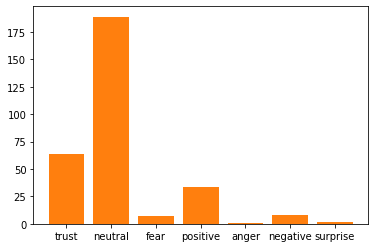

Counter({'anger': 1,
         'fear': 7,
         'negative': 8,
         'neutral': 189,
         'positive': 34,
         'surprise': 2,
         'trust': 64})

<Figure size 432x288 with 0 Axes>

In [ ]:
emotions_counter(Predicted_emotion_dict_list_tagger1)

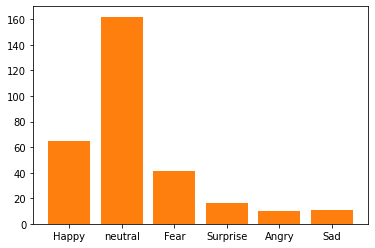

Counter({'Angry': 10,
         'Fear': 41,
         'Happy': 65,
         'Sad': 11,
         'Surprise': 16,
         'neutral': 162})

<Figure size 432x288 with 0 Axes>

In [ ]:
emotions_counter(Predicted_emotion_dict_list_tagger2)

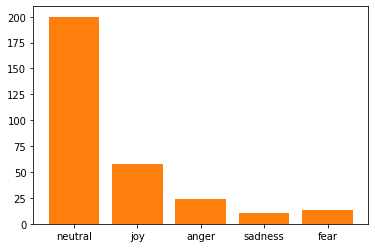

Counter({'anger': 24, 'fear': 13, 'joy': 58, 'neutral': 200, 'sadness': 10})

<Figure size 432x288 with 0 Axes>

In [ ]:
emotions_counter(Predicted_emotion_dict_list_tagger3)

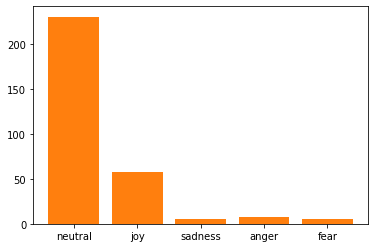

Counter({'anger': 7, 'fear': 5, 'joy': 58, 'neutral': 230, 'sadness': 5})

<Figure size 432x288 with 0 Axes>

In [ ]:
emotions_counter(Predicted_emotion_dict_list_tagger4)

# **Demo for testing**

## Feature extractor module to convert the sentence into features and pass into the model

In [ ]:
def word2features2(sent, i):
    word = sent[i][0]

    features = {
        'curr_word': word.lower(),
        'curr_pos':  sent[i][1],
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isdigit()': word.isdigit(),
        'prev_pos': '.',
        'prev_word': '.',
    }
    if i > 0:
        features.update({
            'prev_word': sent[i-1][0].lower(),
            'prev_pos': sent[i-1][1],
            #'prev_chunk':  sent[i-1][2],  
        })
    else:
        features['BOS'] = True

    if i > 1:
        features.update({
            'prev_prev_word': sent[i-2][0],
            'prev_prev_pos': sent[i-2][1],
           #'prev_prev_chunk':  sent[i-2][2],    
        })

    return features
def sent2features2(sent):
    return [word2features2(sent, i) for i in range(len(sent))]

# def sent2labels(sent):
#     return [label for token, postag, label in sent]
 


## Converting string into features and passing into the model

In [ ]:
## Convert to X_test_inp
def crf_input(input):
  input_1 = input.split()
  sent = []
  for i in range(len(input_1)):
    word = []
    a = input_1[i]
    b = nltk.pos_tag(nltk.word_tokenize(a))[-1][1]
    word.append(a)
    word.append(b)
    sent.append(word)
  output = sent2features2(sent)
  return output

In [ ]:
input_sentence = "the food was good but service was bad "
X_test_inp=[crf_input(input_sentence)]

## Running the pipeline on the input sentence

In [ ]:
y_pred_inp = crf.predict(X_test_inp)
asp_list_pred_inp = []
for k in range(len(X_test_inp)):
  aspect = []
  x = ''
  i=0
  while (i < len(X_test_inp[k])):
    if(y_pred_inp[k][i]=='B-A'):
      x = X_test_inp[k][i]['curr_word']
      if(i<len(X_test_inp[k])-1):
        while(y_pred_inp[k][i+1]=='I-A'):
          x = x +' '+X_test_inp[k][i+1]['curr_word']
          i=i+1
          if(i==len(y_pred_inp[k])-1):
            break
      aspect.append(x)

    i = i+1
  asp_list_pred_inp.append(aspect)
print("Sentence \t =====> \t",input_sentence)
print("Extracted Aspect list \t =====> \t ",asp_list_pred_inp)
#Actual_polarity_dict_list =[]
# Predicted_polarity_dict_list_tagger1=[]
# Predicted_polarity_dict_list_tagger2=[]
# Predicted_polarity_dict_list_tagger3=[]
#for i in range(len(sentences_test)):
for i in range(0,len(X_test_inp)):
  #print(i)
  #Actual_aspects = aspects_list_test[i]
  #print(Actual_aspects)
  #if len(Actual_aspects)==0 or Actual_aspects[0]=="NULL":
    #continue
  Predicted_aspects = asp_list_pred_inp[i]
  #print(Predicted_aspects)
  
  emotion_words_per_aspect_dict=words(input_sentence,Predicted_aspects,nlp)
  print("Extracted dependency words \t =====> \t", emotion_words_per_aspect_dict)
  print("#"*50)
  #except:
   # print("skipped")
    #continue
  #Actual_polarity_dict_list.append(sentences_test[i]['aspect_polarity'])
  #print(i)
  #print("actual - ",sentences_test[i]['aspect_polarity'])
  polarity,emotions=emotion_tagger(emotion_words_per_aspect_dict)
  print("predicted Polarity tagger NRC- \t =====> \t",polarity)
  print("predicted emotions tagger NRC- \t =====> \t",emotions)
  print("#"*50)
  Predicted_polarity_dict_list_tagger1.append(polarity)
  polarity,emotions=emotion_tagger2(emotion_words_per_aspect_dict)
  print("predicted Polarity tagger text2emotion-  =====> \t",polarity)
  print("predicted emotions tagger text2emotions-  =====> \t",emotions)
  print("#"*50)
  Predicted_polarity_dict_list_tagger2.append(polarity)
  polarity,emotions=emotion_tagger_SVM(emotion_words_per_aspect_dict)
  print("predicted Polarity tagger SVM- \t =====> \t",polarity)
  print("predicted emotions tagger SVM- \t =====> \t",emotions)
  print("#"*50)
  Predicted_polarity_dict_list_tagger3.append(polarity)
  polarity,emotions=emotion_tagger_lgr(emotion_words_per_aspect_dict)
  print("predicted Polarity tagger LGR- \t =====> \t",polarity)
  print("predicted emotions tagger LGR- \t =====> \t",emotions)
  print("#"*50)
  Predicted_polarity_dict_list_tagger4.append(polarity)

Sentence 	 =====> 	 the food was good but service was bad 
Extracted Aspect list 	 =====> 	  [['food', 'service']]
Extracted dependency words 	 =====> 	 {'food': ['good'], 'service': ['bad']}
##################################################
predicted Polarity tagger NRC- 	 =====> 	 {'food': 'positive', 'service': 'negative'}
predicted emotions tagger NRC- 	 =====> 	 {'food': 'trust', 'service': 'fear'}
##################################################
predicted Polarity tagger text2emotion-  =====> 	 {'food': 'positive', 'service': 'negative'}
predicted emotions tagger text2emotions-  =====> 	 {'food': 'Happy', 'service': 'Sad'}
##################################################
predicted Polarity tagger SVM- 	 =====> 	 {'food': 'positive', 'service': 'negative'}
predicted emotions tagger SVM- 	 =====> 	 {'food': 'neutral', 'service': 'sadness'}
##################################################
predicted Polarity tagger LGR- 	 =====> 	 {'food': 'positive', 'service': 'negative'}
pr